In [1]:
# ============================================
# LABORATORIO 7 - PUNTO 2
# Dataset: Cardiovascular Disease
# Aprendizaje Semi-Supervisado y Activo
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib as mpl
import random

print("="*70)
print("LABORATORIO 7 - PUNTO 2")
print("Dataset: Cardiovascular Disease")
print("Aprendizaje Semi-Supervisado y Activo")
print("="*70)



LABORATORIO 7 - PUNTO 2
Dataset: Cardiovascular Disease
Aprendizaje Semi-Supervisado y Activo


In [2]:
# ============================================
# 1. CARGA Y EXPLORACIÓN DEL DATASET
# ============================================
print("\n" + "="*70)
print("1. CARGA Y EXPLORACIÓN DEL DATASET")
print("="*70)

# Cargar dataset completo (con target)
df_completo = pd.read_csv('/content/cardio_train.csv', delimiter=';')
print(f"\nDataset completo cargado:")
print(f"  - Forma: {df_completo.shape}")
print(f"  - Ejemplos (m): {df_completo.shape[0]:,}")
print(f"  - Características (n): {df_completo.shape[1]}")

print(f"\n✓ Cumple requisitos del Punto 2:")
print(f"  - m = {df_completo.shape[0]:,} > 10,000 ✓")
print(f"  - n = {df_completo.shape[1]} > 10 ✓")

print("\nPrimeras filas:")
print(df_completo.head())

print("\nInformación de columnas:")
print(df_completo.info())

print("\nEstadísticas descriptivas:")
print(df_completo.describe())

print("\nDistribución del target 'cardio' (enfermedad cardiovascular):")
print(df_completo['cardio'].value_counts())
print(f"  - Sin enfermedad (0): {(df_completo['cardio']==0).sum():,}")
print(f"  - Con enfermedad (1): {(df_completo['cardio']==1).sum():,}")



1. CARGA Y EXPLORACIÓN DEL DATASET

Dataset completo cargado:
  - Forma: (70000, 13)
  - Ejemplos (m): 70,000
  - Características (n): 13

✓ Cumple requisitos del Punto 2:
  - m = 70,000 > 10,000 ✓
  - n = 13 > 10 ✓

Primeras filas:
   id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2     168    62.0    110     80            1     1      0   
1   1  20228       1     156    85.0    140     90            3     1      0   
2   2  18857       1     165    64.0    130     70            3     1      0   
3   3  17623       2     169    82.0    150    100            1     1      0   
4   4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0  

Información de columnas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 colu

In [3]:
# ============================================
# 2. PREPROCESAMIENTO
# ============================================
print("\n" + "="*70)
print("2. PREPROCESAMIENTO DE DATOS")
print("="*70)

# Remover columna 'id' si existe
if 'id' in df_completo.columns:
    df_completo = df_completo.drop('id', axis=1)
    print("✓ Columna 'id' removida")

# Separar features (X) y target (y)
y_original = df_completo['cardio'].copy()
X_original = df_completo.drop('cardio', axis=1)

print(f"\nColumnas de features: {list(X_original.columns)}")

# Convertir edad de días a años
if 'age' in X_original.columns:
    X_original['age'] = X_original['age'] / 365
    print("✓ Edad convertida de días a años")

print("\nEstadísticas de features:")
print(X_original.describe())

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_original)
print(f"\n✓ Datos escalados con StandardScaler")

# Aplicar PCA para reducir dimensionalidad
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f"\n✓ PCA aplicado:")
print(f"  - Dimensiones originales: {X_scaled.shape[1]}")
print(f"  - Dimensiones reducidas: {X_pca.shape[1]}")
print(f"  - Varianza explicada: {pca.explained_variance_ratio_.sum():.4f}")

# Para visualización 2D
X_2d = X_pca[:, :2]





2. PREPROCESAMIENTO DE DATOS
✓ Columna 'id' removida

Columnas de features: ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
✓ Edad convertida de días a años

Estadísticas de features:
                age        gender        height        weight         ap_hi  \
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000   
mean      53.339358      1.349571    164.359229     74.205690    128.817286   
std        6.759594      0.476838      8.210126     14.395757    154.011419   
min       29.583562      1.000000     55.000000     10.000000   -150.000000   
25%       48.394521      1.000000    159.000000     65.000000    120.000000   
50%       53.980822      1.000000    165.000000     72.000000    120.000000   
75%       58.430137      2.000000    170.000000     82.000000    140.000000   
max       64.967123      2.000000    250.000000    200.000000  16020.000000   

              ap_lo   cholesterol          gl

In [4]:
# ============================================
# FUNCIONES DE VISUALIZACIÓN
# ============================================
def plot_data(X):
    """Graficar puntos de datos"""
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    """Graficar centroides con círculos y cruces"""
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=10, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=10,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    """Graficar fronteras de decisión de los clusters"""
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

def plot_clusters(X, y=None):
    """Graficar clusters con colores"""
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)




In [5]:
# ============================================
# ============================================
# 3. APRENDIZAJE SEMI-SUPERVISADO
# ============================================
# ============================================
print("\n" + "="*70)
print("3. APRENDIZAJE SEMI-SUPERVISADO")
print("="*70)
print("\nCONCEPTO: En aprendizaje SEMI-SUPERVISADO usamos:")
print("  - Una PEQUEÑA cantidad de datos etiquetados (10%)")
print("  - Una GRAN cantidad de datos SIN etiquetar (90%)")
print("\nEl algoritmo aprende de los datos sin etiquetar para mejorar")
print("el clustering, aprovechando la estructura natural de los datos.")

# Dividir: 10% etiquetado, 90% sin etiquetar
X_sin_etiquetar, X_etiquetado, y_sin_etiquetar, y_etiquetado = train_test_split(
    X_pca, y_original, test_size=0.1, random_state=42, stratify=y_original)

print(f"\n--- División de datos ---")
print(f"Datos SIN etiquetar: {len(X_sin_etiquetar):,} ({len(X_sin_etiquetar)/len(X_pca)*100:.1f}%)")
print(f"Datos etiquetados:   {len(X_etiquetado):,} ({len(X_etiquetado)/len(X_pca)*100:.1f}%)")
print(f"\nAplicamos K-Means sobre los {len(X_sin_etiquetar):,} datos SIN etiquetar")

# K-Means aleatorio
k_semi = random.randint(2, 8)
print(f"\nK aleatorio seleccionado: {k_semi}")

# Entrenar modelos con diferentes iteraciones
print("\nEntrenando K-Means con 1, 2 y 3 iteraciones...")
kmeans_semi_iter1 = KMeans(n_clusters=k_semi, init="k-means++", n_init=1,
                           algorithm="elkan", max_iter=1, random_state=1)
kmeans_semi_iter2 = KMeans(n_clusters=k_semi, init="k-means++", n_init=1,
                           algorithm="elkan", max_iter=2, random_state=1)
kmeans_semi_iter3 = KMeans(n_clusters=k_semi, init="k-means++", n_init=1,
                           algorithm="elkan", max_iter=3, random_state=1)

X_sin_etiquetar_2d = X_sin_etiquetar[:, :2]
kmeans_semi_iter1.fit(X_sin_etiquetar_2d)
kmeans_semi_iter2.fit(X_sin_etiquetar_2d)
kmeans_semi_iter3.fit(X_sin_etiquetar_2d)




3. APRENDIZAJE SEMI-SUPERVISADO

CONCEPTO: En aprendizaje SEMI-SUPERVISADO usamos:
  - Una PEQUEÑA cantidad de datos etiquetados (10%)
  - Una GRAN cantidad de datos SIN etiquetar (90%)

El algoritmo aprende de los datos sin etiquetar para mejorar
el clustering, aprovechando la estructura natural de los datos.

--- División de datos ---
Datos SIN etiquetar: 63,000 (90.0%)
Datos etiquetados:   7,000 (10.0%)

Aplicamos K-Means sobre los 63,000 datos SIN etiquetar

K aleatorio seleccionado: 3

Entrenando K-Means con 1, 2 y 3 iteraciones...


KMeans(algorithm='elkan', max_iter=3, n_clusters=3, n_init=1, random_state=1)


Generando visualización del proceso iterativo...


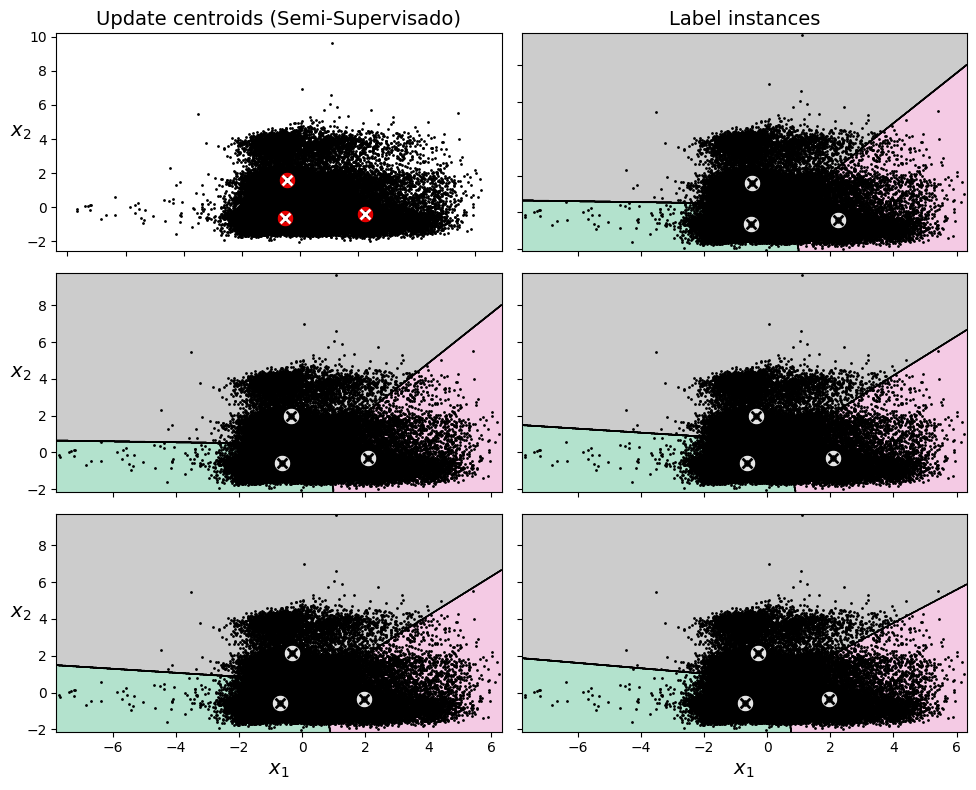

In [6]:
# Visualización del proceso iterativo
print("\nGenerando visualización del proceso iterativo...")
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X_sin_etiquetar_2d)
plot_centroids(kmeans_semi_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update centroids (Semi-Supervisado)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_semi_iter1, X_sin_etiquetar_2d, show_xlabels=False, show_ylabels=False)
plt.title("Label instances", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_semi_iter1, X_sin_etiquetar_2d, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_semi_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_semi_iter2, X_sin_etiquetar_2d, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_semi_iter2, X_sin_etiquetar_2d, show_centroids=False)
plot_centroids(kmeans_semi_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_semi_iter3, X_sin_etiquetar_2d, show_ylabels=False)

plt.tight_layout()
plt.show()



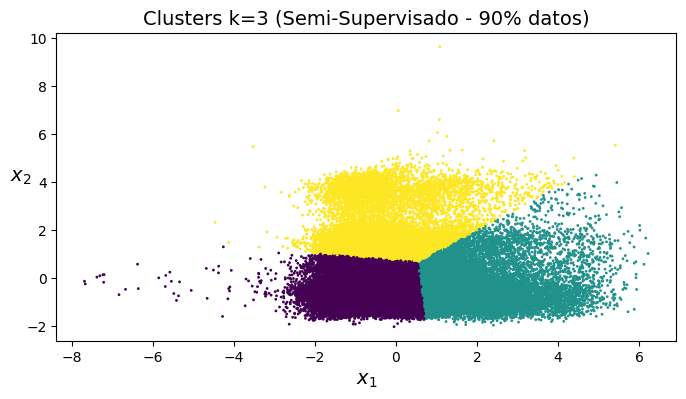

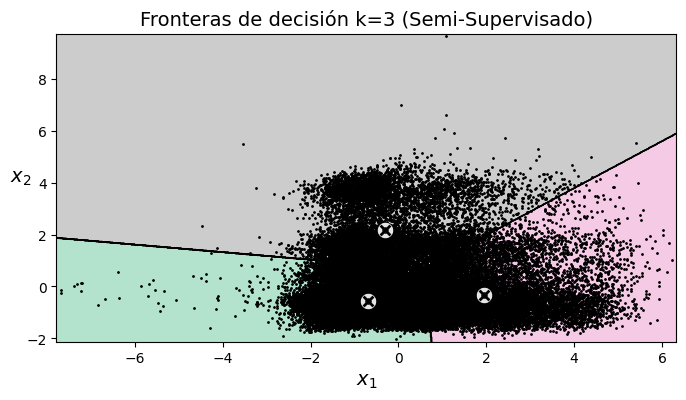

In [7]:
# Visualizaciones finales
plt.figure(figsize=(8, 4))
plot_clusters(X_sin_etiquetar_2d, kmeans_semi_iter3.labels_)
plt.title(f"Clusters k={k_semi} (Semi-Supervisado - 90% datos)", fontsize=14)
plt.show()

plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_semi_iter3, X_sin_etiquetar_2d)
plt.title(f"Fronteras de decisión k={k_semi} (Semi-Supervisado)", fontsize=14)
plt.show()





----------------------------------------------------------------------
MÉTODO DEL CODO (Semi-Supervisado)
----------------------------------------------------------------------

Entrenando modelos para k=1 hasta k=10...
k= 1: Inercia = 673305.55
k= 2: Inercia = 585718.51
k= 3: Inercia = 522665.37
k= 4: Inercia = 464213.22
k= 5: Inercia = 400192.97
k= 6: Inercia = 357251.06
k= 7: Inercia = 316991.24
k= 8: Inercia = 283292.72
k= 9: Inercia = 262581.34
k=10: Inercia = 245970.49


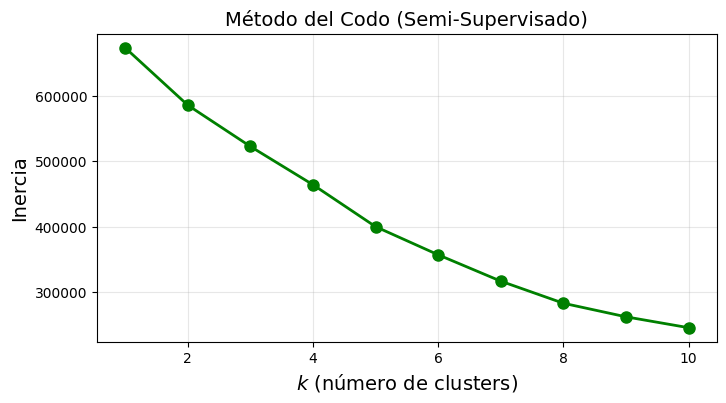

In [8]:
# --- MÉTODO DEL CODO ---
print("\n" + "-"*70)
print("MÉTODO DEL CODO (Semi-Supervisado)")
print("-"*70)

k_range_semi = range(1, 11)
kmeans_semi_models = []
inertias_semi = []

print("\nEntrenando modelos para k=1 hasta k=10...")
for k in k_range_semi:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10,
                    random_state=42, max_iter=300)
    kmeans.fit(X_sin_etiquetar)
    kmeans_semi_models.append(kmeans)
    inertias_semi.append(kmeans.inertia_)
    print(f"k={k:2d}: Inercia = {kmeans.inertia_:.2f}")

plt.figure(figsize=(8, 4))
plt.plot(k_range_semi, inertias_semi, "go-", linewidth=2, markersize=8)
plt.xlabel("$k$ (número de clusters)", fontsize=14)
plt.ylabel("Inercia", fontsize=14)
plt.title("Método del Codo (Semi-Supervisado)", fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()





----------------------------------------------------------------------
SILHOUETTE SCORE (Semi-Supervisado)
----------------------------------------------------------------------

Calculando Silhouette Score para k=2 hasta k=10...
k= 2: Silhouette Score = 0.2141
k= 3: Silhouette Score = 0.3008
k= 4: Silhouette Score = 0.1987
k= 5: Silhouette Score = 0.2334
k= 6: Silhouette Score = 0.2347
k= 7: Silhouette Score = 0.2571
k= 8: Silhouette Score = 0.2626
k= 9: Silhouette Score = 0.2163
k=10: Silhouette Score = 0.2248

Mejor K encontrado: 3
Mejor Silhouette Score: 0.3008


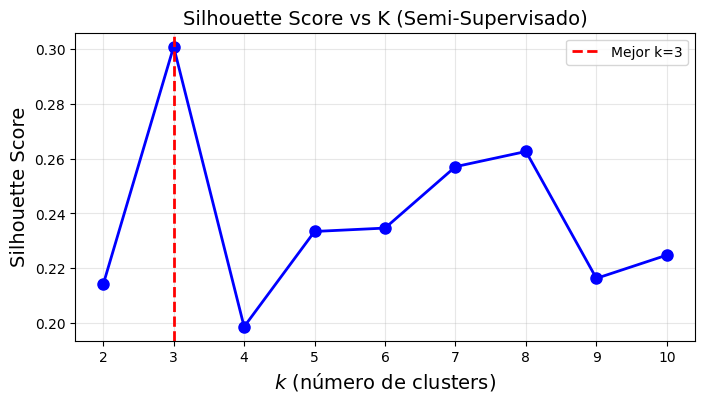

In [9]:
# --- SILHOUETTE SCORE ---
print("\n" + "-"*70)
print("SILHOUETTE SCORE (Semi-Supervisado)")
print("-"*70)

silhouette_scores_semi = []
print("\nCalculando Silhouette Score para k=2 hasta k=10...")
for k in range(2, 11):
    score = silhouette_score(X_sin_etiquetar, kmeans_semi_models[k-1].labels_)
    silhouette_scores_semi.append(score)
    print(f"k={k:2d}: Silhouette Score = {score:.4f}")

best_k_semi = silhouette_scores_semi.index(max(silhouette_scores_semi)) + 2
print(f"\nMejor K encontrado: {best_k_semi}")
print(f"Mejor Silhouette Score: {max(silhouette_scores_semi):.4f}")

plt.figure(figsize=(8, 4))
plt.plot(range(2, 11), silhouette_scores_semi, "bo-", linewidth=2, markersize=8)
plt.xlabel("$k$ (número de clusters)", fontsize=14)
plt.ylabel("Silhouette Score", fontsize=14)
plt.title("Silhouette Score vs K (Semi-Supervisado)", fontsize=14)
plt.axvline(x=best_k_semi, color='red', linestyle='--', linewidth=2,
            label=f'Mejor k={best_k_semi}')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()





----------------------------------------------------------------------
DIAGRAMAS DE SILUETA (Semi-Supervisado)
----------------------------------------------------------------------


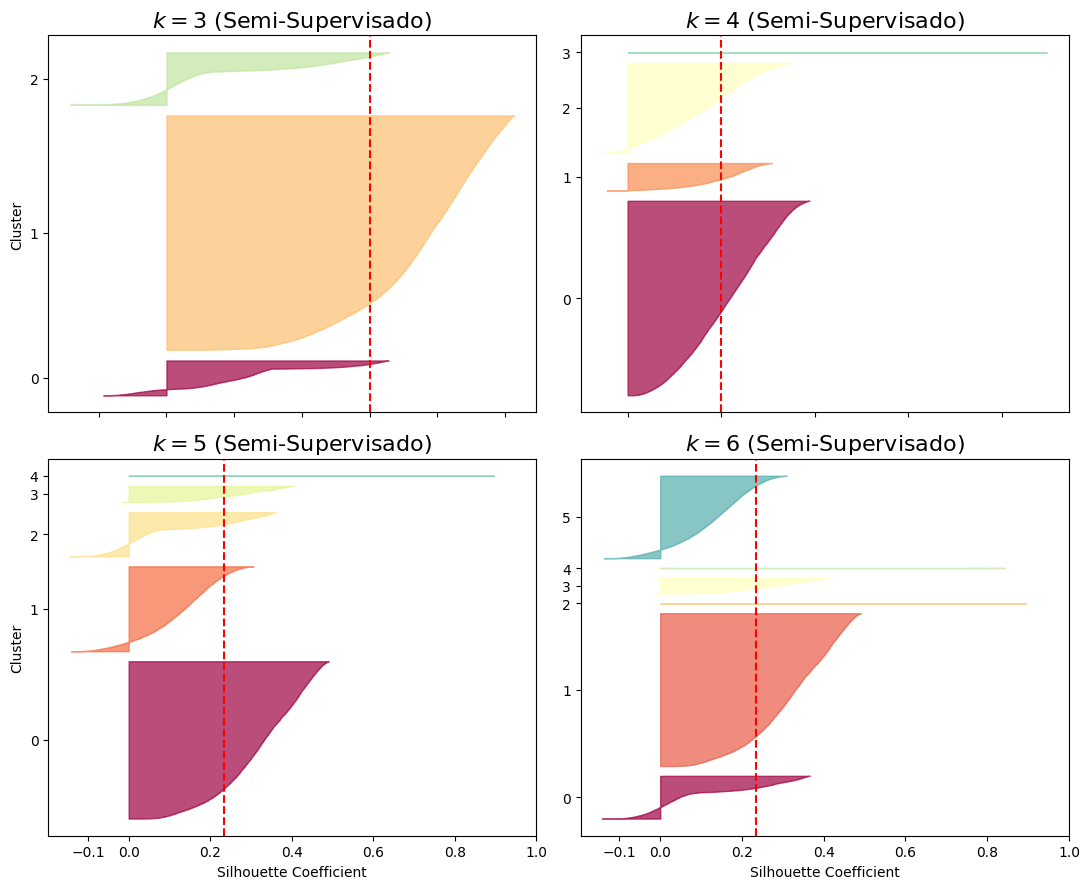


✓ Aprendizaje Semi-Supervisado completado
  - K demostración: 3
  - Mejor K encontrado: 3
  - Mejor Silhouette Score: 0.3008


In [10]:
# --- DIAGRAMAS DE SILUETA ---
print("\n" + "-"*70)
print("DIAGRAMAS DE SILUETA (Semi-Supervisado)")
print("-"*70)

valid_ks_semi = [k for k in (3, 4, 5, 6) if k <= 10]

plt.figure(figsize=(11, 9))

for plot_idx, k in enumerate(valid_ks_semi):
    plt.subplot(2, 2, plot_idx + 1)

    y_pred = kmeans_semi_models[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X_sin_etiquetar, y_pred)

    padding = len(X_sin_etiquetar) // 30
    pos = padding
    ticks = []

    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))

    if k in (3, 5):
        plt.ylabel("Cluster")

    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    if k - 2 < len(silhouette_scores_semi):
        plt.axvline(x=silhouette_scores_semi[k - 2], color="red", linestyle="--")

    plt.title(f"$k={k}$ (Semi-Supervisado)", fontsize=16)

plt.tight_layout()
plt.show()

print(f"\n✓ Aprendizaje Semi-Supervisado completado")
print(f"  - K demostración: {k_semi}")
print(f"  - Mejor K encontrado: {best_k_semi}")
print(f"  - Mejor Silhouette Score: {max(silhouette_scores_semi):.4f}")




In [11]:
# ============================================
# ============================================
# 4. APRENDIZAJE ACTIVO
# ============================================
# ============================================
print("\n" + "="*70)
print("4. APRENDIZAJE ACTIVO")
print("="*70)
print("\nCONCEPTO: En aprendizaje ACTIVO:")
print("  - Comenzamos con MUY POCOS datos etiquetados (5%)")
print("  - El algoritmo SELECCIONA los ejemplos más informativos")
print("  - Un 'experto' etiqueta solo esos ejemplos seleccionados")
print("  - Es útil cuando etiquetar datos es costoso o requiere tiempo")
print("\nSimulamos el proceso con un conjunto inicial pequeño")
print("y un 'pool' grande de datos disponibles para etiquetar.")

# Dividir: 5% etiquetado inicial, 95% pool sin etiquetar
X_pool, X_inicial, y_pool, y_inicial = train_test_split(
    X_pca, y_original, test_size=0.05, random_state=42, stratify=y_original)

print(f"\n--- División de datos ---")
print(f"Pool sin etiquetar:         {len(X_pool):,} ({len(X_pool)/len(X_pca)*100:.1f}%)")
print(f"Conjunto inicial etiquetado: {len(X_inicial):,} ({len(X_inicial)/len(X_pca)*100:.1f}%)")
print(f"\nAplicamos K-Means sobre los {len(X_inicial):,} datos iniciales")




4. APRENDIZAJE ACTIVO

CONCEPTO: En aprendizaje ACTIVO:
  - Comenzamos con MUY POCOS datos etiquetados (5%)
  - El algoritmo SELECCIONA los ejemplos más informativos
  - Un 'experto' etiqueta solo esos ejemplos seleccionados
  - Es útil cuando etiquetar datos es costoso o requiere tiempo

Simulamos el proceso con un conjunto inicial pequeño
y un 'pool' grande de datos disponibles para etiquetar.

--- División de datos ---
Pool sin etiquetar:         66,500 (95.0%)
Conjunto inicial etiquetado: 3,500 (5.0%)

Aplicamos K-Means sobre los 3,500 datos iniciales


In [12]:
# K-Means aleatorio
k_activo = random.randint(2, 8)
print(f"\nK aleatorio seleccionado: {k_activo}")

# Entrenar modelos con diferentes iteraciones
print("\nEntrenando K-Means con 1, 2 y 3 iteraciones...")
kmeans_activo_iter1 = KMeans(n_clusters=k_activo, init="k-means++", n_init=1,
                             algorithm="elkan", max_iter=1, random_state=1)
kmeans_activo_iter2 = KMeans(n_clusters=k_activo, init="k-means++", n_init=1,
                             algorithm="elkan", max_iter=2, random_state=1)
kmeans_activo_iter3 = KMeans(n_clusters=k_activo, init="k-means++", n_init=1,
                             algorithm="elkan", max_iter=3, random_state=1)

X_inicial_2d = X_inicial[:, :2]
kmeans_activo_iter1.fit(X_inicial_2d)
kmeans_activo_iter2.fit(X_inicial_2d)
kmeans_activo_iter3.fit(X_inicial_2d)




K aleatorio seleccionado: 8

Entrenando K-Means con 1, 2 y 3 iteraciones...


KMeans(algorithm='elkan', max_iter=3, n_init=1, random_state=1)


Generando visualización del proceso iterativo...


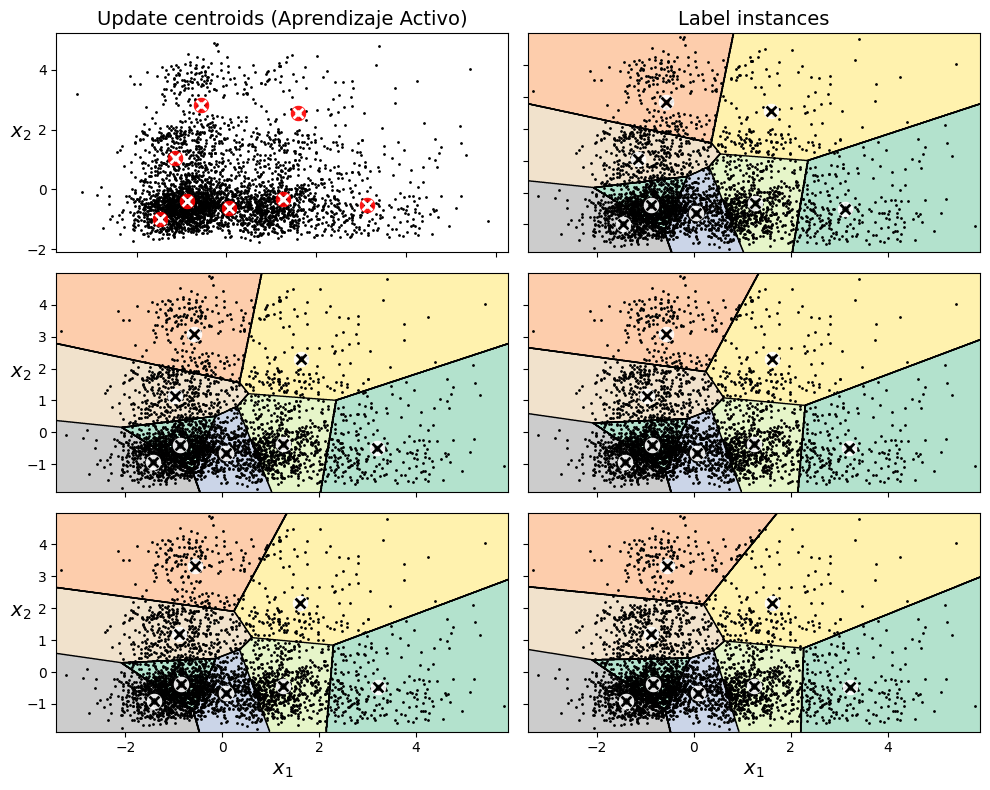

In [13]:
# Visualización del proceso iterativo
print("\nGenerando visualización del proceso iterativo...")
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X_inicial_2d)
plot_centroids(kmeans_activo_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update centroids (Aprendizaje Activo)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_activo_iter1, X_inicial_2d, show_xlabels=False, show_ylabels=False)
plt.title("Label instances", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_activo_iter1, X_inicial_2d, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_activo_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_activo_iter2, X_inicial_2d, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_activo_iter2, X_inicial_2d, show_centroids=False)
plot_centroids(kmeans_activo_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_activo_iter3, X_inicial_2d, show_ylabels=False)

plt.tight_layout()
plt.show()



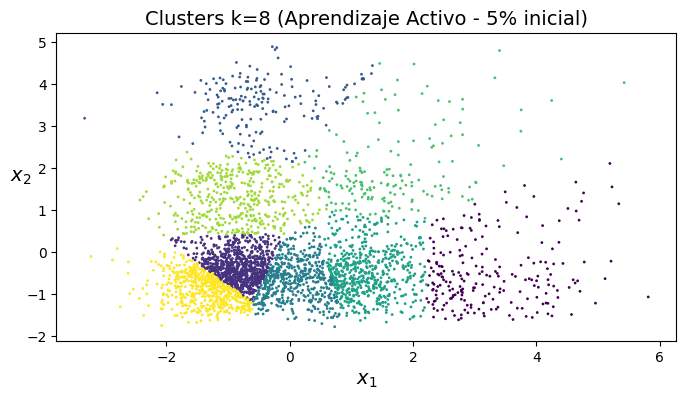

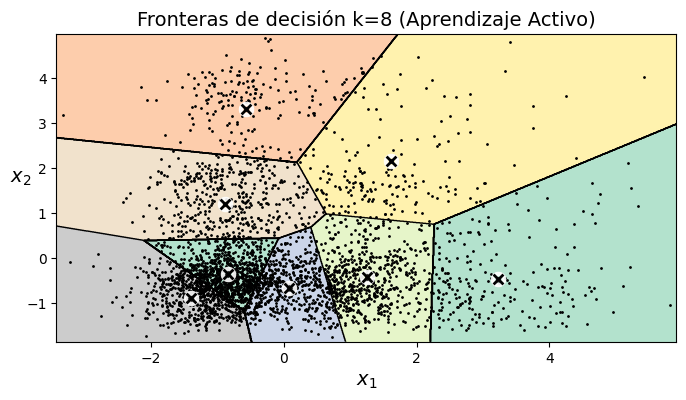

In [14]:
# Visualizaciones finales
plt.figure(figsize=(8, 4))
plot_clusters(X_inicial_2d, kmeans_activo_iter3.labels_)
plt.title(f"Clusters k={k_activo} (Aprendizaje Activo - 5% inicial)", fontsize=14)
plt.show()

plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_activo_iter3, X_inicial_2d)
plt.title(f"Fronteras de decisión k={k_activo} (Aprendizaje Activo)", fontsize=14)
plt.show()





----------------------------------------------------------------------
MÉTODO DEL CODO (Aprendizaje Activo)
----------------------------------------------------------------------

Entrenando modelos para k=1 hasta k=10...
k= 1: Inercia = 33254.20
k= 2: Inercia = 28392.10
k= 3: Inercia = 24972.86
k= 4: Inercia = 22114.47
k= 5: Inercia = 19676.61
k= 6: Inercia = 17231.30
k= 7: Inercia = 15897.56
k= 8: Inercia = 14191.10
k= 9: Inercia = 13090.16
k=10: Inercia = 12392.39


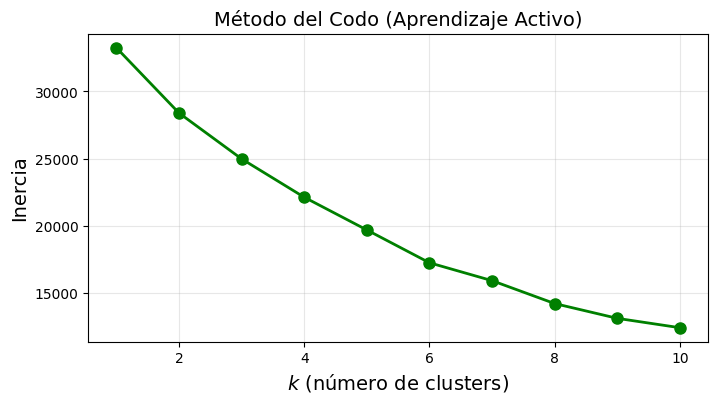

In [15]:
# --- MÉTODO DEL CODO ---
print("\n" + "-"*70)
print("MÉTODO DEL CODO (Aprendizaje Activo)")
print("-"*70)

k_range_activo = range(1, 11)
kmeans_activo_models = []
inertias_activo = []

print("\nEntrenando modelos para k=1 hasta k=10...")
for k in k_range_activo:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10,
                    random_state=42, max_iter=300)
    kmeans.fit(X_inicial)
    kmeans_activo_models.append(kmeans)
    inertias_activo.append(kmeans.inertia_)
    print(f"k={k:2d}: Inercia = {kmeans.inertia_:.2f}")

plt.figure(figsize=(8, 4))
plt.plot(k_range_activo, inertias_activo, "go-", linewidth=2, markersize=8)
plt.xlabel("$k$ (número de clusters)", fontsize=14)
plt.ylabel("Inercia", fontsize=14)
plt.title("Método del Codo (Aprendizaje Activo)", fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()





----------------------------------------------------------------------
SILHOUETTE SCORE (Aprendizaje Activo)
----------------------------------------------------------------------

Calculando Silhouette Score para k=2 hasta k=10...
k= 2: Silhouette Score = 0.2186
k= 3: Silhouette Score = 0.2271
k= 4: Silhouette Score = 0.2396
k= 5: Silhouette Score = 0.2634
k= 6: Silhouette Score = 0.2630
k= 7: Silhouette Score = 0.2515
k= 8: Silhouette Score = 0.2188
k= 9: Silhouette Score = 0.2277
k=10: Silhouette Score = 0.2405

Mejor K encontrado: 5
Mejor Silhouette Score: 0.2634


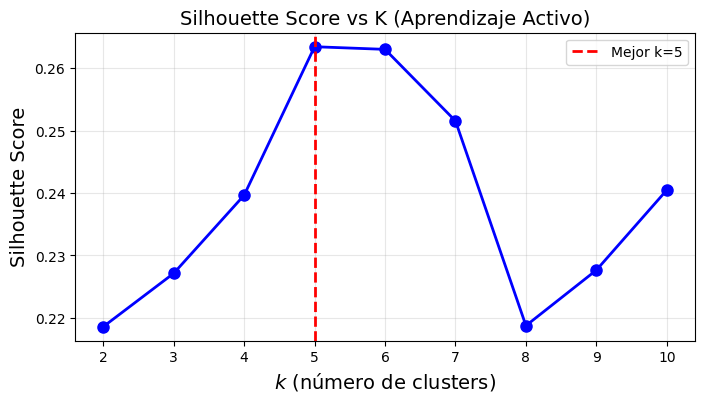

In [16]:
# --- SILHOUETTE SCORE ---
print("\n" + "-"*70)
print("SILHOUETTE SCORE (Aprendizaje Activo)")
print("-"*70)

silhouette_scores_activo = []
print("\nCalculando Silhouette Score para k=2 hasta k=10...")
for k in range(2, 11):
    score = silhouette_score(X_inicial, kmeans_activo_models[k-1].labels_)
    silhouette_scores_activo.append(score)
    print(f"k={k:2d}: Silhouette Score = {score:.4f}")

best_k_activo = silhouette_scores_activo.index(max(silhouette_scores_activo)) + 2
print(f"\nMejor K encontrado: {best_k_activo}")
print(f"Mejor Silhouette Score: {max(silhouette_scores_activo):.4f}")

plt.figure(figsize=(8, 4))
plt.plot(range(2, 11), silhouette_scores_activo, "bo-", linewidth=2, markersize=8)
plt.xlabel("$k$ (número de clusters)", fontsize=14)
plt.ylabel("Silhouette Score", fontsize=14)
plt.title("Silhouette Score vs K (Aprendizaje Activo)", fontsize=14)
plt.axvline(x=best_k_activo, color='red', linestyle='--', linewidth=2,
            label=f'Mejor k={best_k_activo}')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()





----------------------------------------------------------------------
DIAGRAMAS DE SILUETA (Aprendizaje Activo)
----------------------------------------------------------------------


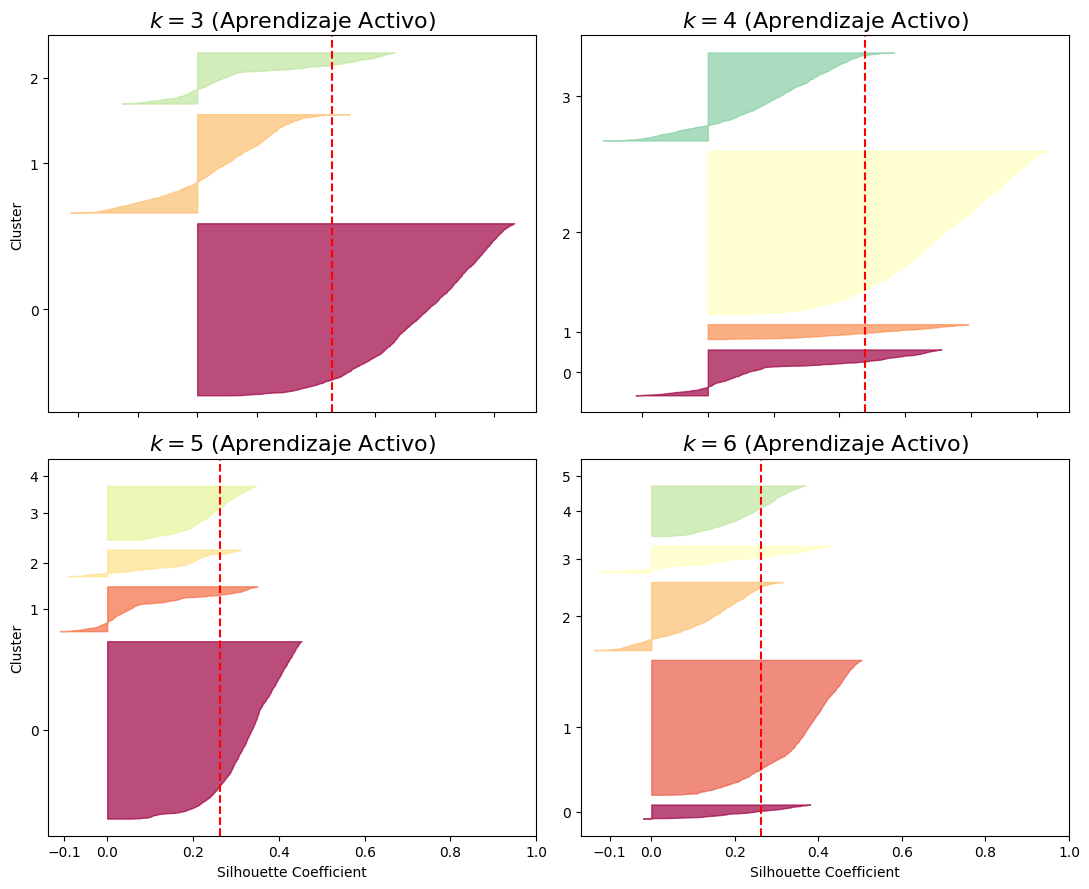


✓ Aprendizaje Activo completado
  - K demostración: 8
  - Mejor K encontrado: 5
  - Mejor Silhouette Score: 0.2634


In [17]:
# --- DIAGRAMAS DE SILUETA ---
print("\n" + "-"*70)
print("DIAGRAMAS DE SILUETA (Aprendizaje Activo)")
print("-"*70)

valid_ks_activo = [k for k in (3, 4, 5, 6) if k <= 10]

plt.figure(figsize=(11, 9))

for plot_idx, k in enumerate(valid_ks_activo):
    plt.subplot(2, 2, plot_idx + 1)

    y_pred = kmeans_activo_models[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X_inicial, y_pred)

    padding = len(X_inicial) // 30
    pos = padding
    ticks = []

    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))

    if k in (3, 5):
        plt.ylabel("Cluster")

    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    if k - 2 < len(silhouette_scores_activo):
        plt.axvline(x=silhouette_scores_activo[k - 2], color="red", linestyle="--")

    plt.title(f"$k={k}$ (Aprendizaje Activo)", fontsize=16)

plt.tight_layout()
plt.show()

print(f"\n✓ Aprendizaje Activo completado")
print(f"  - K demostración: {k_activo}")
print(f"  - Mejor K encontrado: {best_k_activo}")
print(f"  - Mejor Silhouette Score: {max(silhouette_scores_activo):.4f}")




In [18]:
# ============================================
# RESUMEN FINAL
# ============================================
print("\n" + "="*70)
print("RESUMEN FINAL - LABORATORIO 7 PUNTO 2")
print("="*70)

print(f"""
DATASET UTILIZADO:
  - Nombre: Cardiovascular Disease Dataset
  - Ejemplos totales: {len(X_pca):,}
  - Características originales: {X_scaled.shape[1]}
  - Características después de PCA: {X_pca.shape[1]}
  - Cumple requisitos: m > 10,000 ✓ y n > 10 ✓

APRENDIZAJE SEMI-SUPERVISADO:
  - Datos sin etiquetar: {len(X_sin_etiquetar):,} (90%)
  - Datos etiquetados: {len(X_etiquetado):,} (10%)
  - K demostración: {k_semi}
  - Mejor K encontrado: {best_k_semi}
  - Mejor Silhouette Score: {max(silhouette_scores_semi):.4f}

APRENDIZAJE ACTIVO:
  - Pool sin etiquetar: {len(X_pool):,} (95%)
  - Conjunto inicial: {len(X_inicial):,} (5%)
  - K demostración: {k_activo}
  - Mejor K encontrado: {best_k_activo}
  - Mejor Silhouette Score: {max(silhouette_scores_activo):.4f}

MÉTODOS APLICADOS:
  ✓ K-Means (proceso iterativo visualizado)
  ✓ Método del Codo
  ✓ Silhouette Score
  ✓ Diagramas de Silueta detallados
""")



RESUMEN FINAL - LABORATORIO 7 PUNTO 2

DATASET UTILIZADO:
  - Nombre: Cardiovascular Disease Dataset
  - Ejemplos totales: 70,000
  - Características originales: 11
  - Características después de PCA: 10
  - Cumple requisitos: m > 10,000 ✓ y n > 10 ✓

APRENDIZAJE SEMI-SUPERVISADO:
  - Datos sin etiquetar: 63,000 (90%)
  - Datos etiquetados: 7,000 (10%)
  - K demostración: 3
  - Mejor K encontrado: 3
  - Mejor Silhouette Score: 0.3008

APRENDIZAJE ACTIVO:
  - Pool sin etiquetar: 66,500 (95%)
  - Conjunto inicial: 3,500 (5%)
  - K demostración: 8
  - Mejor K encontrado: 5
  - Mejor Silhouette Score: 0.2634

MÉTODOS APLICADOS:
  ✓ K-Means (proceso iterativo visualizado)
  ✓ Método del Codo
  ✓ Silhouette Score
  ✓ Diagramas de Silueta detallados

